## IMPORTING PACKAGES

In [24]:
#Data Management
import pandas as pd
import numpy as np
np.random.seed(0)

from pandas_profiling import ProfileReport

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

#sk-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

#Test
from collections import Counter

## IMPORTING DATASET

In [9]:
train_df = pd.read_csv("C:\\Users\\Mohit\\Desktop\\CSV_files\\twitter_training.csv",names=['Tweet_id','entity','sentiment','tweet_content'])

test_df = pd.read_csv("C:\\Users\\Mohit\\Desktop\\CSV_files\\twitter_validation.csv",names=['Tweet_id','entity','sentiment','tweet_content'])

### Dropping NA values

In [10]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [11]:
train_df.shape

(73996, 4)

#### Subsetting dataset

In [12]:
df = train_df.sample(frac=0.1)
df.reset_index(drop=True,inplace=True)

## DATA EXPLORATION 
    -Basic visualisation
    -Automated Data Exploration with pandas-profiling
    -Checking for balance in output categories

#### Basic Visualisation

In [13]:
#See overall information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_id       7400 non-null   int64 
 1   entity         7400 non-null   object
 2   sentiment      7400 non-null   object
 3   tweet_content  7400 non-null   object
dtypes: int64(1), object(3)
memory usage: 231.4+ KB


In [14]:
df.head()

,Tweet_id,entity,sentiment,tweet_content
0,13040,Xbox(Xseries),Irrelevant,"Death stories gif of the day,"
1,4167,CS-GO,Positive,Tagged by @brntwllm . . fave games i've playe...
2,3197,Dota2,Negative,i admit nothing but my sadness that you're gone
3,4677,Google,Negative,I just won't be impressed until I can even dow...
4,11513,TomClancysRainbowSix,Positive,I am very really much looking forward to tonig...


#### Checking balance of the data in output categories

<BarContainer object of 4 artists>

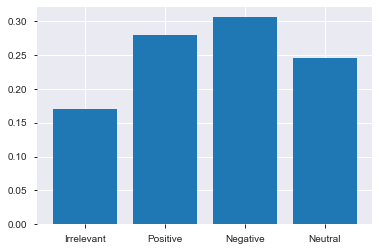

In [26]:
# Checking balance of target classes
sentiments = list(df["sentiment"].unique())

sentiment_nums = [len(df[df["sentiment"]==sentiment])/len(df) for sentiment in sentiments]

plt.bar(sentiments,sentiment_nums)

#### Basic Data Enrichment
    -One-Hot Encoding
    -Enrichment with Pre-Trained NLP Models (TextBlob)
    -Labels to Indexes (and Back Again)

In [27]:
#ONE HOT ENCODING

# View all possible entities

print(df["entity"].unique())
print(len(df["entity"].unique()))

['Xbox(Xseries)' 'CS-GO' 'Dota2' 'Google' 'TomClancysRainbowSix'
 'johnson&johnson' 'PlayerUnknownsBattlegrounds(PUBG)' 'Overwatch'
 'AssassinsCreed' 'RedDeadRedemption(RDR)' 'Borderlands' 'WorldOfCraft'
 'Microsoft' 'MaddenNFL' 'TomClancysGhostRecon' 'Verizon' 'HomeDepot'
 'Fortnite' 'Amazon' 'LeagueOfLegends' 'ApexLegends' 'Facebook'
 'CallOfDuty' 'GrandTheftAuto(GTA)' 'CallOfDutyBlackopsColdWar'
 'Battlefield' 'Nvidia' 'Hearthstone' 'Cyberpunk2077' 'FIFA' 'NBA2K'
 'PlayStation5(PS5)']
32


In [28]:
#One hot encoding ising pandas get_dummies()
onehot = pd.get_dummies(df["entity"],prefix="entity")

#Join bact to dataset
df = df.join(onehot)

df.head()

,Tweet_id,entity,sentiment,tweet_content,entity_Amazon,entity_ApexLegends,entity_AssassinsCreed,entity_Battlefield,entity_Borderlands,entity_CS-GO,...,entity_Overwatch,entity_PlayStation5(PS5),entity_PlayerUnknownsBattlegrounds(PUBG),entity_RedDeadRedemption(RDR),entity_TomClancysGhostRecon,entity_TomClancysRainbowSix,entity_Verizon,entity_WorldOfCraft,entity_Xbox(Xseries),entity_johnson&johnson
0,13040,Xbox(Xseries),Irrelevant,"Death stories gif of the day,",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4167,CS-GO,Positive,Tagged by @brntwllm . . fave games i've playe...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3197,Dota2,Negative,i admit nothing but my sadness that you're gone,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4677,Google,Negative,I just won't be impressed until I can even dow...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11513,TomClancysRainbowSix,Positive,I am very really much looking forward to tonig...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
df = df.drop("entity",axis=1)

#### Enrichment with pre-trained models(TextBlob)

In [30]:
#Adding dimensions with TextBlob
def tb_enrich(ls):
    tb_polarity = []
    tb_subject = []
    
    for tweet in ls:
        tb_polarity.append(TextBlob(tweet).sentiment[0])
        tb_subject.append(TextBlob(tweet).sentiment[1])
        
    return tb_polarity,tb_subject

df["Polarity"],df["Subjectivity"] = tb_enrich(list(df["tweet_content"]))

In [31]:
df.head()

,Tweet_id,sentiment,tweet_content,entity_Amazon,entity_ApexLegends,entity_AssassinsCreed,entity_Battlefield,entity_Borderlands,entity_CS-GO,entity_CallOfDuty,...,entity_PlayerUnknownsBattlegrounds(PUBG),entity_RedDeadRedemption(RDR),entity_TomClancysGhostRecon,entity_TomClancysRainbowSix,entity_Verizon,entity_WorldOfCraft,entity_Xbox(Xseries),entity_johnson&johnson,Polarity,Subjectivity
0,13040,Irrelevant,"Death stories gif of the day,",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.000000,0.000000
1,4167,Positive,Tagged by @brntwllm . . fave games i've playe...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.038095,0.352381
2,3197,Negative,i admit nothing but my sadness that you're gone,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
3,4677,Negative,I just won't be impressed until I can even dow...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,1.000000
4,11513,Positive,I am very really much looking forward to tonig...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.150000,0.500000


#### Labels to indexes(and back again)

Here, as discussed above, we create a dictionary in order to change the text in the "Sentiment" column into an index representing the predicted sentiment.

We then convert the "Sentiment" column in the training data to the labels, which is what we will learn to predict

In [32]:
#Define the indexing for each possible label in dictionary
class_to_index = {"Neutral":0,"Irrelevant":0,"Negative":2,"Positive":3}

#Create a reverse dictionary
index_to_class = {0:"Neutral/Irrelevant",2:"Negative",3:"Positive"}

#Create lambda function, applying the correct dictionary
name_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_name = lambda n: np.array([index_to_class.get(x) for x in n])

In [34]:
#Test each function
print(name_to_ids(["Positive", "Negative", "Irrelevant", "Neutral"]))
print(ids_to_name([0,1,2,3]))

[3 2 0 0]
['Neutral/Irrelevant' None 'Negative' 'Positive']


In [37]:
#Convert the "Sentiment" column into indexes
df["sentiment"] = name_to_ids(df["sentiment"])

In [38]:
df.head()

,Tweet_id,sentiment,tweet_content,entity_Amazon,entity_ApexLegends,entity_AssassinsCreed,entity_Battlefield,entity_Borderlands,entity_CS-GO,entity_CallOfDuty,...,entity_PlayerUnknownsBattlegrounds(PUBG),entity_RedDeadRedemption(RDR),entity_TomClancysGhostRecon,entity_TomClancysRainbowSix,entity_Verizon,entity_WorldOfCraft,entity_Xbox(Xseries),entity_johnson&johnson,Polarity,Subjectivity
0,13040,0,"Death stories gif of the day,",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.000000,0.000000
1,4167,3,Tagged by @brntwllm . . fave games i've playe...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.038095,0.352381
2,3197,2,i admit nothing but my sadness that you're gone,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.000000
3,4677,2,I just won't be impressed until I can even dow...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,1.000000
4,11513,3,I am very really much looking forward to tonig...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.150000,0.500000


### NLP DATA ENRICHMENT
    
    -Stop Word Removal and Lemmatisation with NLTK
    -Tokenisation
    -Adding the Tokenised Strings to the DataFrame

In [49]:
def remove_stopwords(ls):
    #Lemmatises, then removes stop words
    ls = [lemmatiser.lemmatize(word) for word in ls if word not in (stop_english) and (word.isalpha())]
    
    #Joins the words back into a single string
    ls = " ".join(ls)
    return ls

#Splits each string into a list of words
df["tweet_content_split"] = df["tweet_content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["tweet_content_split"] = df["tweet_content_split"].apply(remove_stopwords)

In [50]:
df.head()

,Tweet_id,sentiment,tweet_content,entity_Amazon,entity_ApexLegends,entity_AssassinsCreed,entity_Battlefield,entity_Borderlands,entity_CS-GO,entity_CallOfDuty,...,entity_RedDeadRedemption(RDR),entity_TomClancysGhostRecon,entity_TomClancysRainbowSix,entity_Verizon,entity_WorldOfCraft,entity_Xbox(Xseries),entity_johnson&johnson,Polarity,Subjectivity,tweet_content_split
0,13040,0,"Death stories gif of the day,",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.000000,0.000000,Death story gif day
1,4167,3,Tagged by @brntwllm . . fave games i've playe...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.038095,0.352381,Tagged brntwllm fave game played enjoyed remem...
2,3197,2,i admit nothing but my sadness that you're gone,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,admit nothing sadness gone
3,4677,2,I just won't be impressed until I can even dow...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.000000,1.000000,I impressed I even download food
4,11513,3,I am very really much looking forward to tonig...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,-0.150000,0.500000,I really much looking forward tonight game mus...


#### TOKENISATION

In [51]:
#Define the Tokeniser
tokeniser = Tokenizer(num_words=1000, lower=True)

#Create the corpus by finding the most common 
tokeniser.fit_on_texts(df["tweet_content_split"])

In [52]:
#Tokenise our column of edited Tweet content
tweet_tokens = tokeniser.texts_to_matrix(list(df["tweet_content_split"]))

In [53]:
tweet_tokens.shape

(7400, 1000)

#### Adding the Tokenised Strings to the DataFrame

In [54]:
#Combining the dataframe with the tokens using pd.concat
full_df = pd.concat([df, pd.DataFrame(tweet_tokens)], sort=False, axis=1)
full_df.shape

(7400, 1038)

### Final Data Preparation

#### Dropping Unused Data

In [58]:
#Remove dependent variable
y = full_df["sentiment"]

#Drop all non-useful columns
full_df = full_df.drop(["sentiment", "Tweet_id", "tweet_content", "tweet_content_split"], axis=1)

In [59]:
#Display final shape
full_df.shape

(7400, 1034)

#### Train-Test-Split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(full_df, y, test_size=0.2, random_state=1)

## Model Construction and Training

#### Model Construction

In [61]:
#Test model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=1034, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

#### Training

In [62]:
h = model.fit(
     X_train, y_train,
     validation_data=(X_test, y_test),
     epochs=30,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/30
185/185 [==============================] - 1s 4ms/step - loss: 1.1079 - accuracy: 0.4461 - val_loss: 0.9355 - val_accuracy: 0.5122
Epoch 2/30
185/185 [==============================] - 0s 2ms/step - loss: 0.8752 - accuracy: 0.5674 - val_loss: 0.8532 - val_accuracy: 0.6041
Epoch 3/30
185/185 [==============================] - 0s 2ms/step - loss: 0.7601 - accuracy: 0.6640 - val_loss: 0.8524 - val_accuracy: 0.6169
Epoch 4/30
185/185 [==============================] - 0s 2ms/step - loss: 0.6718 - accuracy: 0.7172 - val_loss: 0.8744 - val_accuracy: 0.6203
Epoch 5/30
185/185 [==============================] - 0s 2ms/step - loss: 0.6053 - accuracy: 0.7569 - val_loss: 0.9064 - val_accuracy: 0.6122
Epoch 6/30
185/185 [==============================] - 0s 2ms/step - loss: 0.5426 - accuracy: 0.7861 - val_loss: 0.9809 - val_accuracy: 0.6000
Epoch 7/30
185/185 [==============================] - 0s 2ms/step - loss: 0.4870 - accuracy: 0.8179 - val_loss: 1.0672 - val_accuracy: 0.6203
Epoch 

### Model Evaluation

In [64]:
#Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_name(y_pred)
y_test_labels = ids_to_name(y_test)

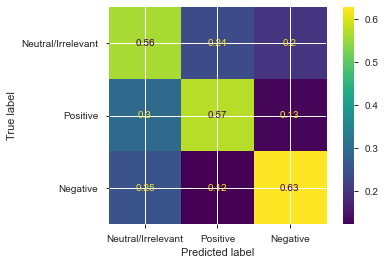

In [65]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

### TRAINING WITH FULL DATASET

In [66]:
#Use the full dataset!
df = train_df

# the test dataframe was loaded earlier and is named test_df

In [67]:
#One-hot encode using Pandas' get_dummies()

##Train
onehot = pd.get_dummies(df["entity"], prefix="entity")

#Join these new columns back into the DataFrame
df = df.join(onehot)


##Test
onehot = pd.get_dummies(test_df["entity"], prefix="entity")

test_df = test_df.join(onehot)

In [68]:
#Enrich using TextBlob's built in sentiment analysis

##Train
df["Polarity"], df["Subjectivity"] = tb_enrich(list(df["tweet_content"]))


##Test
test_df["Polarity"], test_df["Subjectivity"] = tb_enrich(list(test_df["tweet_content"]))

In [70]:
#Convert the "Sentiment" column into indexes

##Train
df["sentiment"] = name_to_ids(df["sentiment"])
y = df["sentiment"]

##Test
test_df["sentiment"] = name_to_ids(test_df["sentiment"])
y_test = test_df["sentiment"]

#### NLP Data Enrichment

In [71]:
#Removing stopwords and lemmatising

##Train
#Splits each string into a list of words
df["tweet_content_split"] = df["tweet_content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["tweet_content_split"] = df["tweet_content_split"].apply(remove_stopwords)

##Test
test_df["tweet_content_split"] = test_df["tweet_content"].apply(word_tokenize)

test_df["tweet_content_split"] = test_df["tweet_content_split"].apply(remove_stopwords)

In [72]:
#Tokenisation

#Define the Tokeniser
tokeniser = Tokenizer(num_words=1000, lower=True)

#Create the corpus by finding the most common 
tokeniser.fit_on_texts(df["tweet_content_split"])

##Train
#Tokenise our column of edited Tweet content
tweet_tokens = tokeniser.texts_to_matrix(list(df["tweet_content_split"]))

##Test
#Tokenise our column of edited Tweet content
tweet_tokens_test = tokeniser.texts_to_matrix(list(test_df["tweet_content_split"]))

In [73]:
#Combining the dataframe with the tokens using pd.concat

#Reset axes to avoid overlapping
df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

##Train
full_df = pd.concat([df, pd.DataFrame(tweet_tokens)], sort=False, axis=1)

##Test
full_test_df = pd.concat([test_df, pd.DataFrame(tweet_tokens_test)], sort=False, axis=1)

In [74]:
#Final prep

##Train
#Drop all non-useful columns
full_df = full_df.drop(["sentiment", "Tweet_id", "tweet_content", "tweet_content_split", "entity"], axis=1)


##Test
full_test_df = full_test_df.drop(["sentiment", "Tweet_id", "tweet_content", "tweet_content_split", "entity"], axis=1)

#### Model Definition and Training

In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=1034, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [76]:
h = model.fit(
     full_df, y,
     epochs=30,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/30
2313/2313 [==============================] - 4s 1ms/step - loss: 0.8265 - accuracy: 0.6187
Epoch 2/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.6945 - accuracy: 0.6989
Epoch 3/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.6239 - accuracy: 0.7366
Epoch 4/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.5773 - accuracy: 0.7596
Epoch 5/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.5431 - accuracy: 0.7765
Epoch 6/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.5229 - accuracy: 0.7869
Epoch 7/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.5045 - accuracy: 0.7962
Epoch 8/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.4900 - accuracy: 0.8032
Epoch 9/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.4794 - accuracy: 0.8081
Epoch 10/30
2313/2313 [==============================] - 3s 1ms/step - loss: 0.468

### FINAL MODEL EVALUATION

In [77]:
#Generate predictions
y_pred = np.argmax(model.predict(full_test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_name(y_pred)
y_test_labels = ids_to_name(y_test)

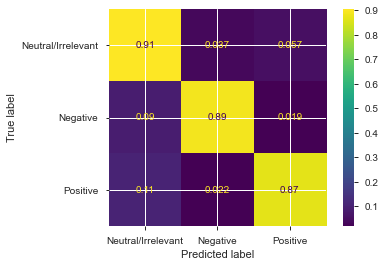

In [78]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [79]:
#To see the final accuracy
accuracy_score(y_test, y_pred)

0.892